# Data validation
The main idea of this notebook is to validate the dataset ready for training (using dataloaders). We will check if the data is consistent and if there are any missing values. First we load the libraries and the data:

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import torch
import cv2
from torch.utils.data import DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from collections import defaultdict
import altair as alt

# To add src to the path so that we can import modules
current_directory = os.getcwd()
if not current_directory.endswith("emotion_recognition"):
    sys.path.append(os.path.join(current_directory, 'emotion_recognition'))

try:
    from src import ROOT_DIR, PROCESSED_AFFECTNET_DIR, NUMBER_OF_EMOT
    from src.visualization.visualize import  visualize_batch, compute_cat_label_batch_entropy
    from src.data.dataset import AffectNetDatasetValidation
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

The flags for preprocessing the data are:

In [2]:
# Path of the parameters file
params_path = os.path.join(ROOT_DIR,"params.yaml")

# Read data preparation parameters
with open(params_path, "r", encoding='utf-8') as params_file:
    try:
        params = yaml.safe_load(params_file)
        params = params["preprocessing"]
    except yaml.YAMLError as exc:
        print(exc)

# Convert the params dictionary to a DataFrame
params_df = pd.DataFrame.from_dict(params, orient='index', columns=['Value'])
# Print the DataFrame
print(params_df)

                                Value
random_seed                        33
orig_datasets             [affectnet]
train_split                       0.8
categorical_format         hard_label
continuous_format           cartesian
face_detection_algorithm         None


for 

In [3]:
for data_split in ["train.pkl", "val.pkl", "test.pkl"]:
    break
    print(f"Processing {data_split}-------------------")
    data = pd.read_pickle(os.path.join(PROCESSED_AFFECTNET_DIR, data_split))
    print(f"Shape of the data: {data.shape}")
    print(data.info())

We check ranges of categorical and continuous variables for any inconsistencies (we take small subset of the data for this purpose to speed up the process):

In [4]:
for data_split in os.listdir(PROCESSED_AFFECTNET_DIR):
    break
    if data_split.endswith('.pkl'):
        print(f"-------------------\tAnalyzing {data_split}\t-------------------")
        data = pd.read_pickle(os.path.join(PROCESSED_AFFECTNET_DIR, data_split))
        random_idx_list = np.random.randint(0, len(data), 2500)
        for idx in random_idx_list:
            sample = data.iloc[idx]               
            # Check if the variables type
            if not isinstance(sample['img_path'], str):
                print(f"Index: {idx}, img_path is not a string.")
            if not isinstance(sample['cat_emot'], torch.Tensor):
                print(f"Index: {idx}, cat_emot is not a PyTorch tensor.")
            if not isinstance(sample['cont_emot'], torch.Tensor):
                print(f"Index: {idx}, cont_emot is not a PyTorch tensor.")

            # Check if the variables are in correct format
            if sample['cat_emot'].numpy().sum() != 1 or len(sample['cat_emot'].numpy()) != NUMBER_OF_EMOT: # Check if the encoding sums to 1, i.e. one-hot encoding (it can be soft or hard)
                print (f"Index: {idx}, cat_emot is has incorrect encoding.")
            if sample['cont_emot'].numpy().shape != (2,):
                    print(f"Index: {idx}, cont_emot has more than 2 values.")
            if params['continuous_format'] == 'cartesian':
                if sample['cont_emot'].numpy()[0] < -1 or sample['cont_emot'].numpy()[0] > 1:
                    print(f"Index: {idx}, valence is not in the range [-1, 1].")
                if sample['cont_emot'].numpy()[1] < -1 or sample['cont_emot'].numpy()[1] > 1:
                    print(f"Index: {idx}, arousal is not in the range [-1, 1].")
            elif params['continuous_format'] == 'polar':
                if sample['cont_emot'].numpy()[0] < 0 or sample['cont_emot'].numpy()[0] > 1:
                    print(f"Index: {idx}, radius is not in the range [0, 1].")
                if sample['cont_emot'].numpy()[1] < 0 or sample['cont_emot'].numpy()[1] > np.pi:
                    print(f"Index: {idx}, phase is not in the range [0, pi].")

# Batch creation
First I will create a batch of data and check if the dataloader works correctly. I will use a subset of size batch_size * bacthes for this purpose.

In [5]:
batch_size = 32
batches = 100
selected_rows = range(batch_size*batches)
np.random.seed(33)  # Set the seed for reproducibility

Now I load the data and create the data dataloaders:

In [6]:
# Create the datasets
dataset_train = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "train.pkl"))
dataset_val = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "val.pkl"))
dataset_test = AffectNetDatasetValidation(annotations_path=os.path.join(PROCESSED_AFFECTNET_DIR, "test.pkl"))
# Take a subset of the datasets
dataset_train = torch.utils.data.Subset(dataset_train, selected_rows)
dataset_val = torch.utils.data.Subset(dataset_val, selected_rows)
dataset_test = torch.utils.data.Subset(dataset_test, selected_rows)
# Create the dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Now I will plot the first batch of data to check if the dataloader works correctly (for training split):

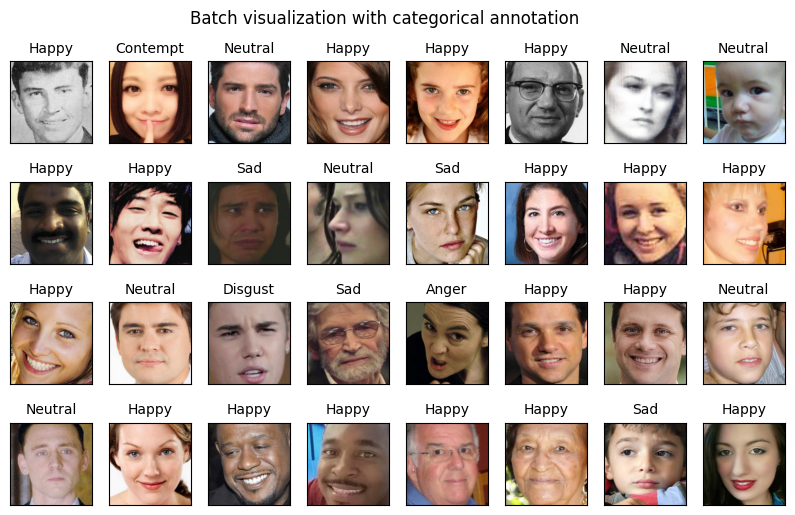

In [7]:
dataiter = iter(dataloader_train)
_, img, cat_label, cont_label = next(dataiter)
visualize_batch(img, cat_label)

# Weighted data loader
As we have seen in data exploration, it is a heavy bias towards positive emotions, concretly to happy and neutral emotions. We how often they are seen in each batch using entropy. Entropy is the measure of suprise or uncertainty of the variables possible outcomes. So it is a good measure to see how uncertain the categorical labels in a batch will be. This is the definition:

$$H(X):=-\sum_{x\in \mathcal{X}} p(x)· log(p(x))$$

**Note:** The choice of base for the logarithm, varies for different applications. I will use base $e$, so it is in "natural units" nat.

The lower bound of entropy is a deterministic event, where in a batch we have only one emotion (in this case the entropy is 0).
$$H(D)=- 1 · log(1)=-log(1) = 0$$

The objective is that all batches labels are as uncertain as possible. So we seek the uniform distribution of categorical labels in each batch. In case of the uniform distribution (of 8 possible outcomes or emotions): 
$$H(U)=-\sum_{i=1}^{8}  1/8 · log(p(i))=-log(1/8) \approx 2.079$$

Now we have a look at the entropy of the labels in the batches for all data splits:

In [8]:
bar_plot_train = compute_cat_label_batch_entropy(dataloader_train, NUMBER_OF_EMOT, title = "Train")
bar_plot_val = compute_cat_label_batch_entropy(dataloader_val, NUMBER_OF_EMOT, title = "Validation")
bar_plot_test = compute_cat_label_batch_entropy(dataloader_test, NUMBER_OF_EMOT, title = "Test")
alt.hconcat(bar_plot_train, bar_plot_val, bar_plot_test).properties(
    title = alt.Title("Entropy of batches regarding the categorical labels in the datasets", anchor = "middle", fontSize = 20))

alt.HConcatChart(...)

We can observe that `train` and `validation` splits have a similar entropy and far from the upper bound, as these splits have unbalanced labels. Some emotions are more common so there is "less suprise" that they appear in the batch. This means that if we forward these batches to the model, it will have a bias to predict the most common emotions. This is not the case for the `test` split, as it has a higher entropy closer to the upper bound that represents the uniform distribution. This is due to the fact that the test split by nature was created to be as close as possible to the uniform distribution of the labels. There is few variability in the entropy of the batches as the sampling from the dataset is random (so this uniformity may change). 

The idea is to create a weighted dataloader, so that the model sees the same amount of each emotion in each batch. This is important because the model will learn to predict the most common emotion if the distribution of emotions is not uniform. First I load the data weights generated from data preprocessing:

In [9]:
train_weights = torch.load(os.path.join(PROCESSED_AFFECTNET_DIR, "data_weights_train.pt"))

Now we create the weighted random sampler.The weight for each class is the reciprocal of the count. This will ensure that classes with a higher representation will have a smaller weight.

In [10]:
reduced_train_weights = torch.empty(len(dataset_train))
print(len(dataset_train))
it = 0 # Index of the reduced_train_weights
for idx in dataset_train.indices:
    reduced_train_weights[it] = train_weights[idx]
    it += 1

3200


In [11]:
sampler = WeightedRandomSampler(reduced_train_weights, len(dataset_train), replacement=True)
dataloader_train_weighted = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, sampler=sampler)

Here, we can see that we have provided our calculated sample weights as an argument and set replacement as True; without this, we would not be able to oversample at all. For now, we have just set the number of samples as the length of our dataset, but we will discuss this more later. 

From this, we can see that our batches are quite well balanced! Looking at the number of images seen, we can see that the sampler has done this by oversampling the minority class and undersampling the majority class.

In [12]:
selected_rows = range(min(batch_size*batches, len(dataset_train)))
bar_plot_train = compute_cat_label_batch_entropy(dataloader_train, NUMBER_OF_EMOT, title = "Train without weighting")
bar_plot_train_weighted = compute_cat_label_batch_entropy(dataloader_train_weighted, NUMBER_OF_EMOT, title = "Train weighted")
alt.hconcat(bar_plot_train, bar_plot_train_weighted).properties(
    title = alt.Title("Entropy of batches with/out weighted sampling", anchor = "middle", fontSize = 20))

alt.HConcatChart(...)

Focus on how we have to wait to see all the emotions. 734e 2427387238497238479283y823yyr2yyhusfdiwf enI take now whole dataset and use the precomputed weights to create the weighted dataloader:

In [33]:
total_images = batch_size * batches
sampler = WeightedRandomSampler(reduced_train_weights, len(dataset_train), replacement=True)
dataloader_train_weighted = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, sampler=sampler)

In [98]:
total_epochs = 20
image_counts = defaultdict(int)
image_emotion = defaultdict(int)
distinct_images_seen = []
emotions_reseen = []
for epoch in range (total_epochs):
    for i, (ids, _, cat_emot, _) in enumerate(dataloader_train_weighted):
        emot = cat_emot.argmax(dim=1).numpy()
        it = 0
        for id in ids.numpy():
            # Increment the count for id in image_counts
            image_counts[id] += 1
            if id not in image_emotion:
                image_emotion[id] = emot[it]  
            it += 1
    # Update the distinct_images_seen for the epoch
    distinct_images_seen.append({'Epoch': epoch, 'Seen dataset': len(image_counts)/total_images}) 
    print(f"Epoch {epoch} - Seen dataset: {len(image_counts)/total_images}")
    for id in image_counts:
        emotions_reseen.append({'Epoch': epoch, 'Emotion': image_emotion[id], 'Count': image_counts[id]})
        
    if distinct_images_seen[epoch] == len(dataloader_train_weighted):
        break

Epoch 0 - Seen dataset: 0.4315625
Epoch 1 - Seen dataset: 0.6125
Epoch 2 - Seen dataset: 0.724375
Epoch 3 - Seen dataset: 0.8021875
Epoch 4 - Seen dataset: 0.854375
Epoch 5 - Seen dataset: 0.895625
Epoch 6 - Seen dataset: 0.926875
Epoch 7 - Seen dataset: 0.9471875
Epoch 8 - Seen dataset: 0.963125
Epoch 9 - Seen dataset: 0.9709375
Epoch 10 - Seen dataset: 0.97875
Epoch 11 - Seen dataset: 0.9828125
Epoch 12 - Seen dataset: 0.9875
Epoch 13 - Seen dataset: 0.9909375
Epoch 14 - Seen dataset: 0.99375
Epoch 15 - Seen dataset: 0.995625
Epoch 16 - Seen dataset: 0.99625
Epoch 17 - Seen dataset: 0.996875
Epoch 18 - Seen dataset: 0.9971875
Epoch 19 - Seen dataset: 0.9975


Now we look how often a certain a same image of a certain emotion is seen (get an oversampling or undersampling notion): 

In [101]:
distinct_images_seen_df = pd.DataFrame(distinct_images_seen).groupby(['Epoch', 'Emotion']).mean().reset_index()


KeyError: 'Emotion'

In [50]:
distinct_images_seen_df = pd.DataFrame.from_dict(distinct_images_seen)

    Epoch  Seen dataset
0       0      0.439375
1       1      0.605625
2       2      0.720625
3       3      0.792188
4       4      0.847812
5       5      0.885312
6       6      0.914062
7       7      0.936875
8       8      0.953438
9       9      0.966562
10     10      0.974375
11     11      0.980000
12     12      0.983125
13     13      0.990625
14     14      0.994062
15     15      0.995000
16     16      0.996563
17     17      0.996875
18     18      0.997188
19     19      0.997500


In [88]:
line_plot = alt.Chart(distinct_images_seen_df).mark_line().encode(
    x=alt.X('Epoch', title='Epoch', scale = alt.Scale(domain = (0, 19))),
    y=alt.Y('Seen dataset:Q', title='Acumulative seen dataset'),
    tooltip=[
        alt.Tooltip('Epoch', title='Epoch'),
        alt.Tooltip('Seen dataset', title='Acumulative seen dataset', format='.2%')
    ]
).properties(
    height=300,
    width=600,
)

line_plot += alt.Chart(distinct_images_seen_df).mark_point().encode(
    x=alt.X('Epoch', title='Epoch', scale = alt.Scale(domain = (0, 19))),
    y='Seen dataset:Q',
    tooltip=[
        alt.Tooltip('Epoch', title='Epoch'),
        alt.Tooltip('Seen dataset', title='Percentage of dataset seen', format='.2%')
    ]
)

line_plot += alt.Chart(pd.DataFrame({'value': [0.95]})).mark_rule(color='black', strokeDash=[5, 5]).encode(
    y='value:Q'
)

line_plot += alt.Chart(pd.DataFrame({'text': ['Confidence of 95%']})).mark_text(
    baseline='middle',
    dx = -215,
    dy = 7,
    fontSize=12,
).encode(
    y=alt.value(0.95),
    text='text'
)

line_plot.properties(title=alt.Title("Acumulative seen dataset per epoch", anchor="middle", fontSize=20))

alt.LayerChart(...)

Now I will make many experiments and see the point where they surpass 95%

In [73]:
total_experiments = 15
threshold = 0.95
epoch_results = []

for experiment in range(total_experiments):
    print(f"Experiment {experiment} -")
    total_epochs = 20
    image_set = set()
    for epoch in range (total_epochs):
        for i, (ids, _, _, _) in enumerate(dataloader_train_weighted):
            for id in ids.numpy():
                image_set.add(id)        
        print(f"Epoch {epoch} - Seen dataset: {len(image_set)/total_images}")
        if len(image_set) > threshold * total_images:
            epoch_results.append(epoch)
            break

Experiment 0 -
Epoch 0 - Seen dataset: 0.434375
Epoch 1 - Seen dataset: 0.6178125
Epoch 2 - Seen dataset: 0.7334375
Epoch 3 - Seen dataset: 0.808125
Epoch 4 - Seen dataset: 0.8590625
Epoch 5 - Seen dataset: 0.891875
Epoch 6 - Seen dataset: 0.9190625
Epoch 7 - Seen dataset: 0.9384375
Epoch 8 - Seen dataset: 0.954375
Experiment 1 -
Epoch 0 - Seen dataset: 0.434375
Epoch 1 - Seen dataset: 0.6146875
Epoch 2 - Seen dataset: 0.7325
Epoch 3 - Seen dataset: 0.7990625
Epoch 4 - Seen dataset: 0.850625
Epoch 5 - Seen dataset: 0.888125
Epoch 6 - Seen dataset: 0.915
Epoch 7 - Seen dataset: 0.9340625
Epoch 8 - Seen dataset: 0.95
Epoch 9 - Seen dataset: 0.9609375
Experiment 2 -
Epoch 0 - Seen dataset: 0.4328125
Epoch 1 - Seen dataset: 0.6159375
Epoch 2 - Seen dataset: 0.7309375
Epoch 3 - Seen dataset: 0.8040625
Epoch 4 - Seen dataset: 0.851875
Epoch 5 - Seen dataset: 0.88875
Epoch 6 - Seen dataset: 0.914375
Epoch 7 - Seen dataset: 0.935
Epoch 8 - Seen dataset: 0.951875
Experiment 3 -
Epoch 0 - Seen d

KeyboardInterrupt: 

Now we make a hist plot of the points where the model surpasses 95% seen dataset:

In [ ]:
# Convert epoch_results to a pandas DataFrame
df_epoch_results = pd.DataFrame({'Epoch': epoch_results})

Show the results after 30 experiments

In [ ]:
# Create the histogram plot
hist_plot = alt.Chart(df_epoch_results).mark_bar().encode(
    x=alt.X('Epoch:Q', bin=alt.Bin(maxbins=20), title='Epoch'),
    y=alt.Y('count():Q', title='Frequency')
).properties(
    title='Histogram of Epoch Results'
)

hist_plot
